# Interpretability & Model Inspection

One way to probe the models we build is to test them against the established knowledge of domain experts. In this final section, we’ll explore how to build intuitions about our machine learning model and avoid pitfalls like spurious correlations. These methods for model interpretability increase our trust into models, but they can also serve as an additional level of reproducibility in our research and a valuable research artefact that can be discussed in a publication.

This part of the tutorial will also go into some considerations why the feature importance of tree-based methods can serve as a start but often shouldn’t be used as the sole source of truth regarding feature interpretation of our applied research.

This section will introduce tools like `shap`, discuss feature importance, and manual inspection of models.

In [1]:
from pathlib import Path

DATA_FOLDER = Path("..") / "data"
DATA_FILEPATH = DATA_FOLDER / "penguins_clean.csv"

In [2]:
import pandas as pd
penguins = pd.read_csv(DATA_FILEPATH)
penguins.head()

,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Species
0,39.1,18.7,181.0,MALE,Adelie Penguin (Pygoscelis adeliae)
1,39.5,17.4,186.0,FEMALE,Adelie Penguin (Pygoscelis adeliae)
2,40.3,18.0,195.0,FEMALE,Adelie Penguin (Pygoscelis adeliae)
3,36.7,19.3,193.0,FEMALE,Adelie Penguin (Pygoscelis adeliae)
4,39.3,20.6,190.0,MALE,Adelie Penguin (Pygoscelis adeliae)


In [3]:
from sklearn.model_selection import train_test_split
num_features = ["Culmen Length (mm)", "Culmen Depth (mm)", "Flipper Length (mm)"]
cat_features = ["Sex"]
features = num_features + cat_features
target = ["Species"]

X_train, X_test, y_train, y_test = train_test_split(penguins[features], penguins[target[0]], stratify=penguins[target[0]], train_size=.7, random_state=42)

In [4]:
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from joblib import dump, load

MODEL_FOLDER = Path("..") / "model"
MODEL_EXPORT_FILE = MODEL_FOLDER / "svc.joblib"

model = load(MODEL_EXPORT_FILE)
model.score(X_test, y_test)

1.0

## Scikit-Learn Inspection


In [5]:
from sklearn.inspection import PartialDependenceDisplay, partial_dependence, plot_partial_dependence

pd_results = partial_dependence(model, X_train.sample(20), num_features)
pd_results

{'average': array([[[[ 2.12204942,  2.12257158,  2.12275015, ...,  0.94321302,
            0.92835839,  0.91091099],
          [ 2.16510118,  2.16614743,  2.16748563, ...,  1.00121113,
            0.9683405 ,  0.91843658],
          [ 2.17858542,  2.17974662,  2.18135551, ...,  1.03217747,
            0.99331414,  0.92387951],
          ...,
          [ 2.23863346,  2.24002656,  2.24232644, ...,  2.19016032,
            2.17195201,  2.07049397],
          [ 2.23676687,  2.23818129,  2.24051823, ...,  2.18844634,
            2.1703692 ,  2.07050255],
          [ 2.23570524,  2.23713142,  2.23948868, ...,  2.1874164 ,
            2.16939344,  2.07029836]],
 
         [[ 2.11940873,  2.11975158,  2.11953229, ...,  0.93112796,
            0.91784151,  0.90435007],
          [ 2.16375183,  2.16469825,  2.16581646, ...,  0.98404969,
            0.95391137,  0.91082196],
          [ 2.17764279,  2.17872479,  2.18015998, ...,  1.01544436,
            0.97716015,  0.91585558],
          ...,
  

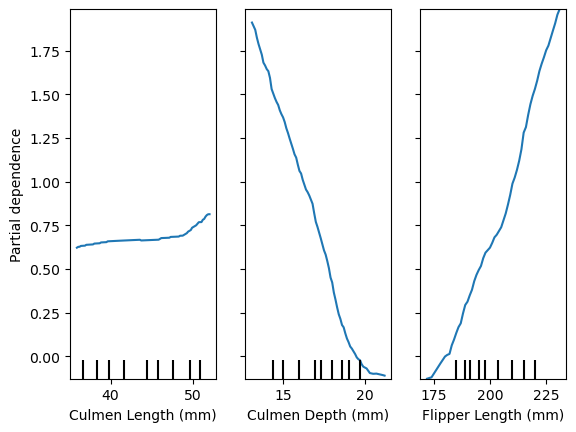

In [6]:
from matplotlib import pyplot as plt

PartialDependenceDisplay.from_estimator(model, X_train, [0,1,2], target=list(y_train.unique())[0])
plt.show()

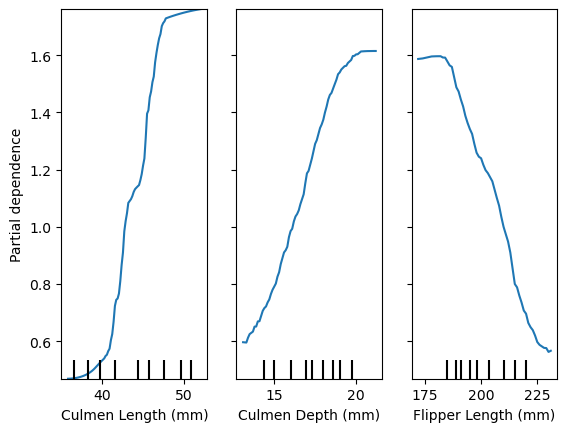

In [7]:
PartialDependenceDisplay.from_estimator(model, X_train, [0,1,2], target=list(y_train.unique())[1])
plt.show()

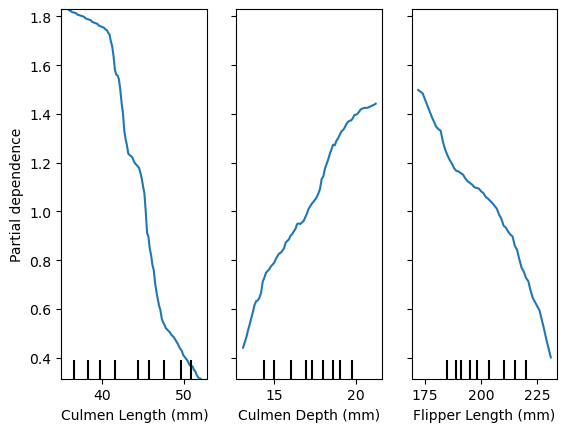

In [8]:
PartialDependenceDisplay.from_estimator(model, X_train, [0,1,2], target=list(y_train.unique())[2])
plt.show()

### Tree importance vs Permutation importance

In [9]:
from sklearn.ensemble import RandomForestClassifier

num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])

rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier()),
])

rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.9900990099009901

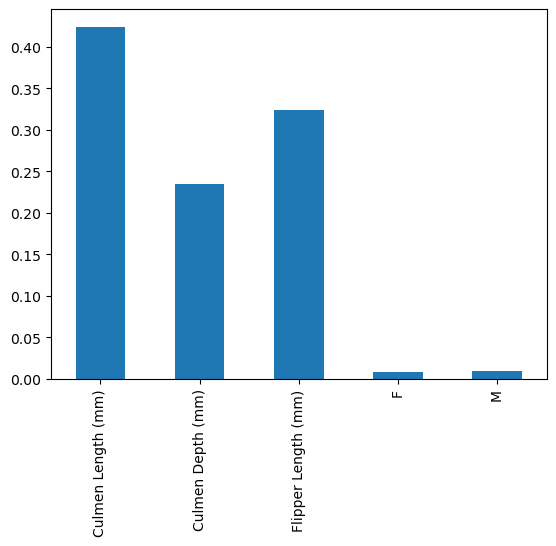

In [10]:
pd.Series(rf.named_steps["classifier"].feature_importances_, index=num_features+['F', 'M']).plot.bar()
plt.show()

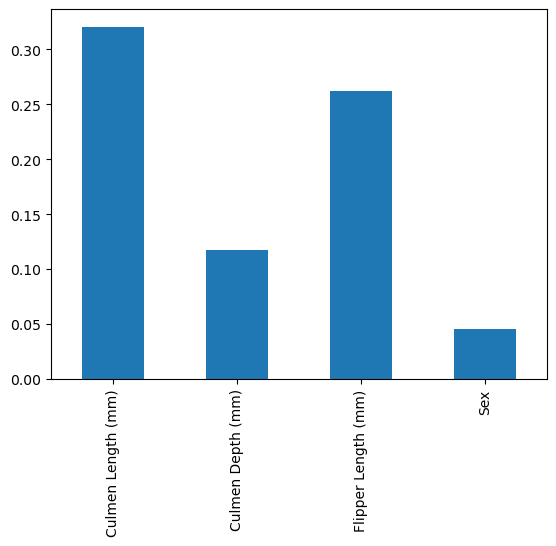

In [11]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rf, X_test, y_test, n_repeats=10, random_state=42
)

pd.Series(result.importances_mean, index=features).plot.bar()
plt.show()

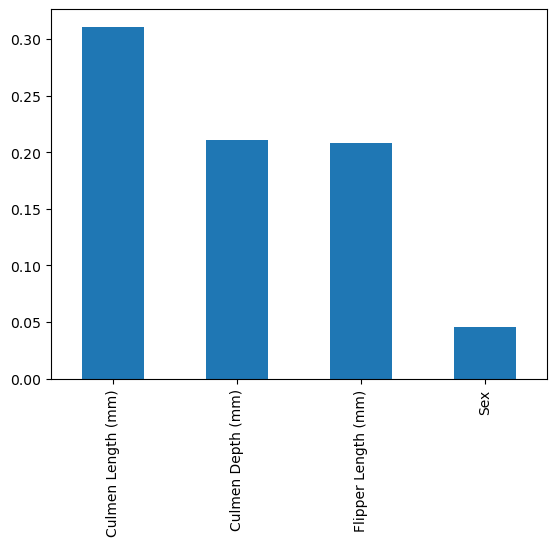

In [12]:
result = permutation_importance(
    model, X_test, y_test, n_repeats=10, random_state=42
)

pd.Series(result.importances_mean, index=features).plot.bar()
plt.show()

## Shap Inspection


In [13]:
import shap

rf = RandomForestClassifier()
rf.fit(X_train[num_features], y_train)

explainer = shap.Explainer(rf)
explainer

In [14]:
shap_values = explainer.shap_values(X_test[num_features])

In [15]:
shap.initjs()

In [16]:
shap.force_plot(explainer.expected_value[0], shap_values[0][0], feature_names=num_features)

In [17]:
shap.force_plot(explainer.expected_value[0], shap_values[0], feature_names=num_features)

## Model Inspection

There are several tools that work for figuring out that a model is doing what it's supposed to do. Scikit-learn classifiers mostly work out of the box, which is why we don't necessarily have to debug the models.

Sometimes we have to switch off regularization in scikit-learn to achieve the model state we expect.

In neural networks we are working with many moving parts. The first step is a practical step: Overfit a small batch of data on the network. This ensures that the model is capable of learning and all the connections are made as expected. This works as a first-order sense check that models are performing.

A more in-depth solution for Pytorch is [Pytorch Surgeon](https://github.com/archinetai/surgeon-pytorch), which can be used to extract submodels of the complete architecture for debugging purposes.

Some example code from the Pytorch Surgeon Docs (torch and surgeon are not installed to save space):


In [18]:
import torch
import torch.nn as nn
from surgeon_pytorch import Extract, get_nodes

class SomeModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(5, 3)
        self.layer2 = nn.Linear(3, 2)
        self.layer3 = nn.Linear(1, 1)

    def forward(self, x):
        x1 = torch.relu(self.layer1(x))
        x2 = torch.sigmoid(self.layer2(x1))
        y = self.layer3(x2).tanh()
        return y

model = SomeModel()
print(get_nodes(model)) # ['x', 'layer1', 'relu', 'layer2', 'sigmoid', 'layer3', 'tanh']

['x', 'layer1', 'relu', 'layer2', 'sigmoid', 'layer3', 'tanh']


This enables us to extract the model at one of the nodes above:

In [19]:
model_ext = Extract(model, node_out='sigmoid')
x = torch.rand(1, 5)
sigmoid = model_ext(x)
print(sigmoid) # tensor([[0.5570, 0.3652]], grad_fn=<SigmoidBackward0>)

tensor([[0.4896, 0.3990]], grad_fn=<SigmoidBackward0>)
